## AMES Housing Data - Predicting House Prices
The AMES housing data is a dataset of 1460 observations with 38 variables. In this experiment, the target variable is SalePrice.

Two tasks are conducted in this document - 1: EDA for variable selection; and 2: Build an OLS regression model and 4 Random Forest models comparing with a 2x2 experiment. The data in this experiment will not be scaled. 

A final table will present results of the experiment with commentary and recommendations. 


In [0]:
# import packages as needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from timeit import default_timer as timer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

In [2]:
# upload files
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [3]:
import io
data = pd.read_csv(io.BytesIO(uploaded['train.csv']))
print(data.describe())

                Id   MSSubClass  ...       YrSold      SalePrice
count  1460.000000  1460.000000  ...  1460.000000    1460.000000
mean    730.500000    56.897260  ...  2007.815753  180921.195890
std     421.610009    42.300571  ...     1.328095   79442.502883
min       1.000000    20.000000  ...  2006.000000   34900.000000
25%     365.750000    20.000000  ...  2007.000000  129975.000000
50%     730.500000    50.000000  ...  2008.000000  163000.000000
75%    1095.250000    70.000000  ...  2009.000000  214000.000000
max    1460.000000   190.000000  ...  2010.000000  755000.000000

[8 rows x 38 columns]


In [0]:
# get a quick look at the data
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,

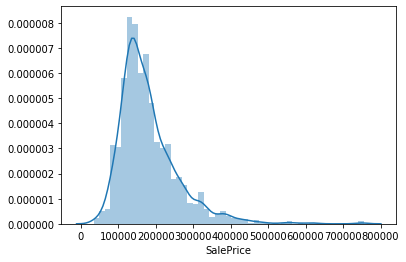

In [0]:
# distribution of SalePrice
sns.distplot(data['SalePrice'])
plt.show()

In [4]:
# build a list of the columns
cols = list(data)
print(cols)

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC'

In [0]:
# create new variables
data['Qual_Cond'] = data['OverallQual'] * data['OverallCond']
data['TotalSqft'] = data['TotalBsmtSF'] + data['GrLivArea']


In [0]:
# subset of data for correlation analysis
corr_data = data[['LotFrontage', 'LotArea', 'Street', 'OverallQual', 'OverallCond', 'Qual_Cond', 'TotalSqft', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 
                 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
                 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']]

In [0]:
# subset of categorical data for analysis
cat_data = data.drop(columns = ['LotFrontage', 'LotArea', 'Street', 'OverallQual', 'OverallCond', 'Qual_Cond', 'TotalSqft', 'YearBuilt', 'YearRemodAdd', 
                                'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                                'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                                'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                                'PoolArea', 'MiscVal', 'MoSold', 'YrSold'], axis=1)

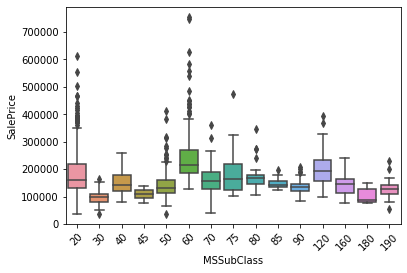

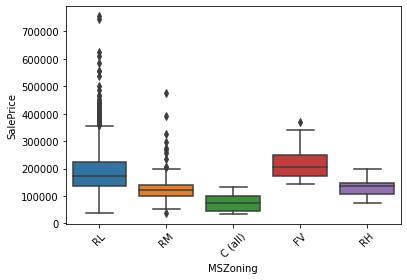

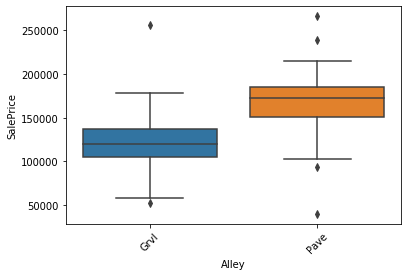

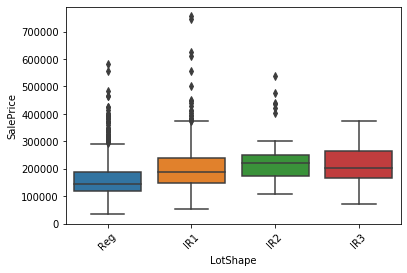

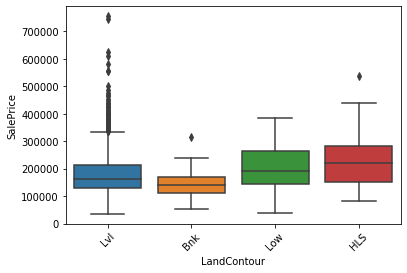

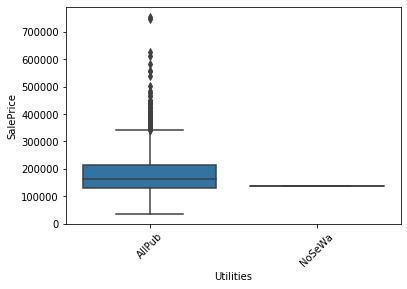

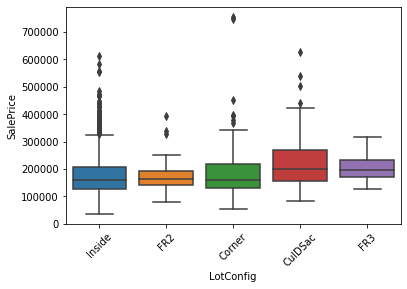

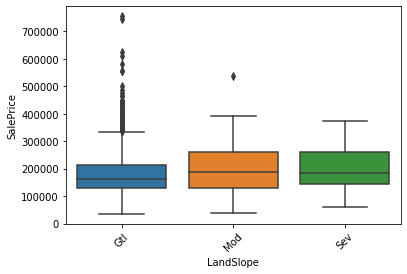

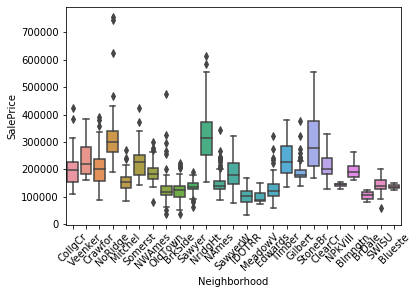

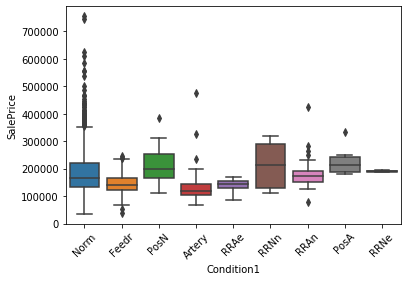

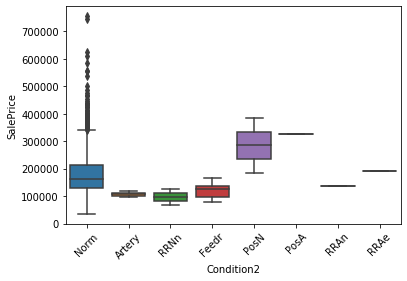

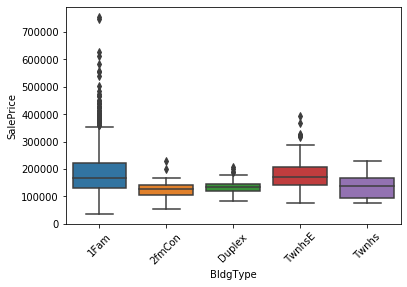

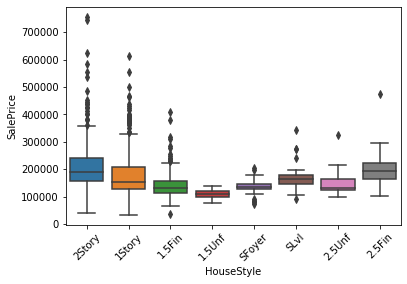

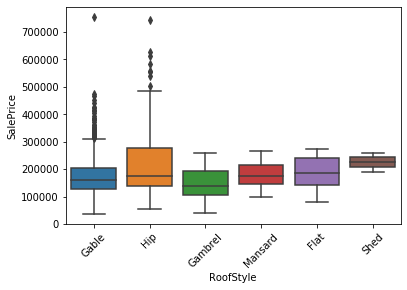

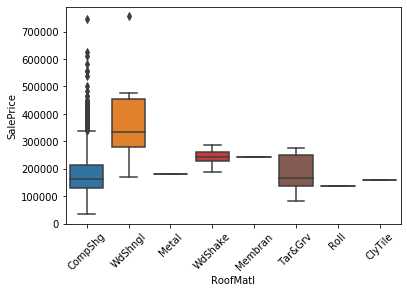

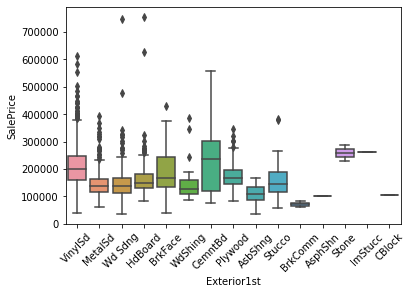

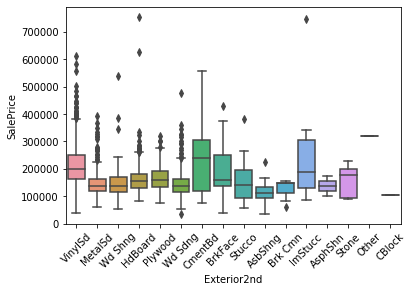

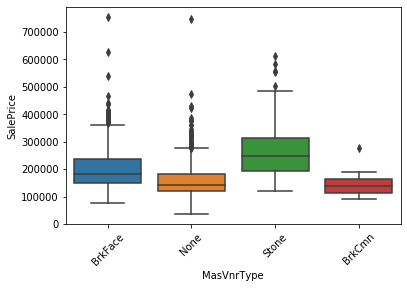

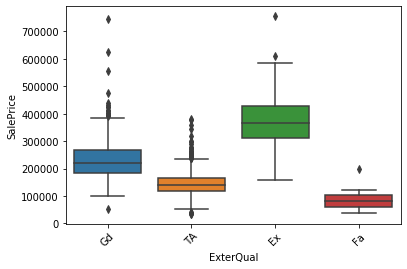

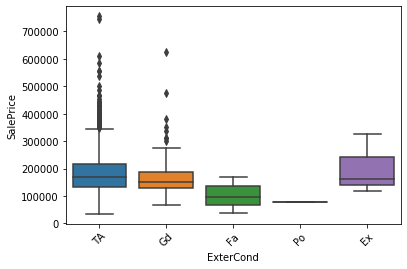

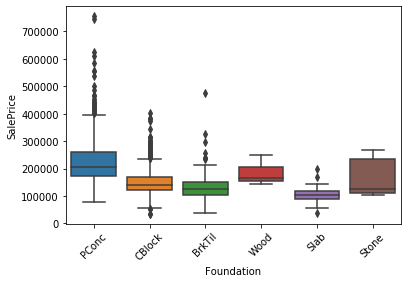

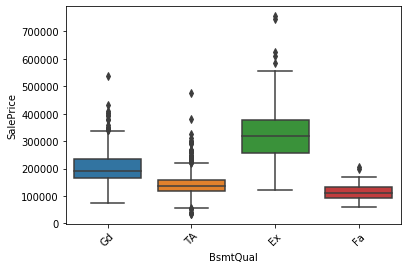

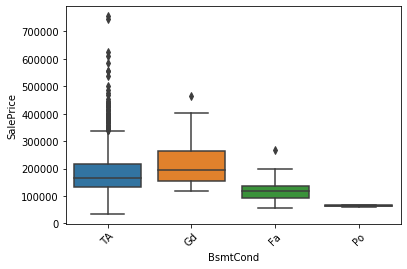

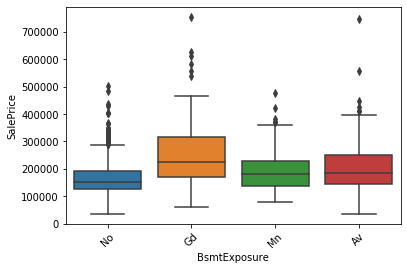

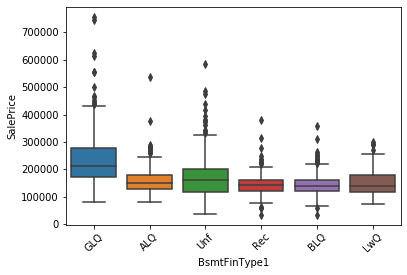

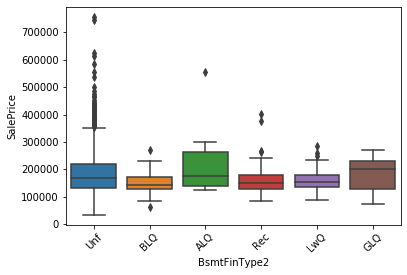

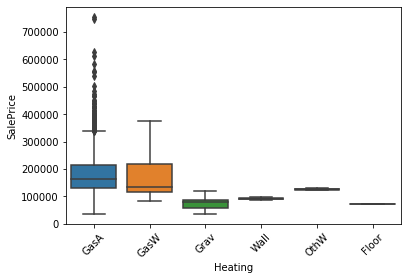

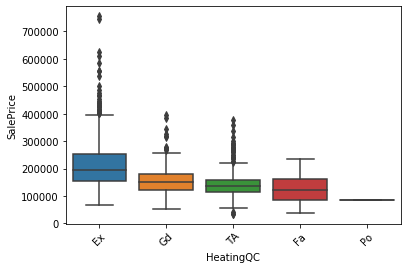

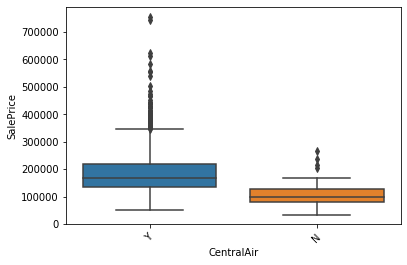

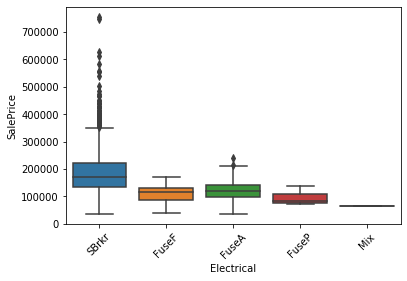

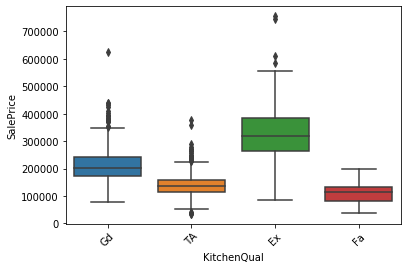

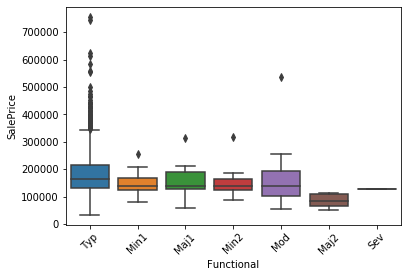

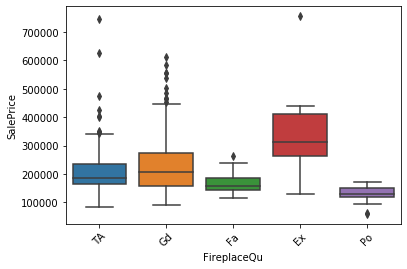

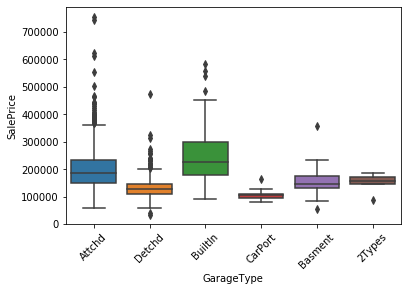

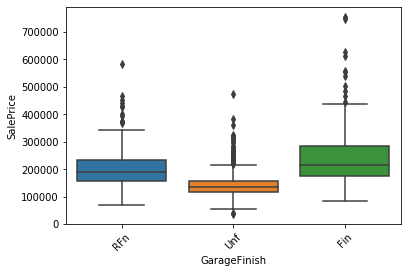

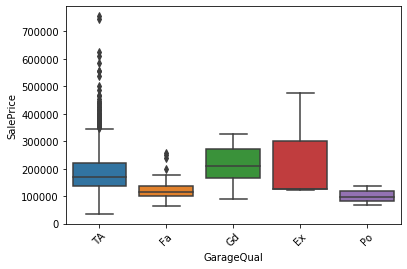

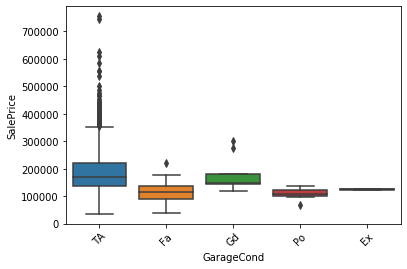

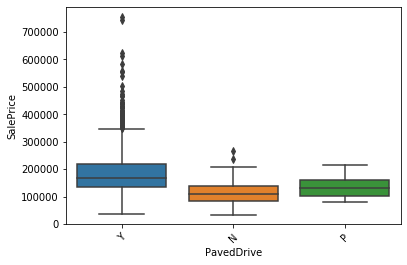

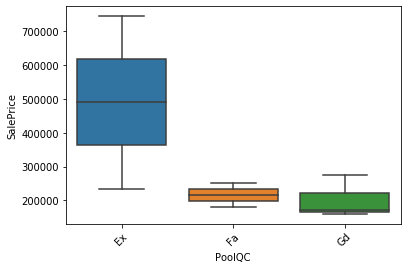

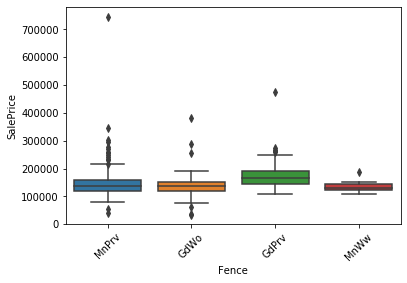

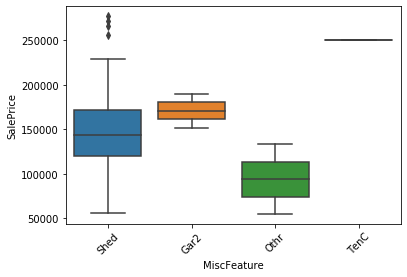

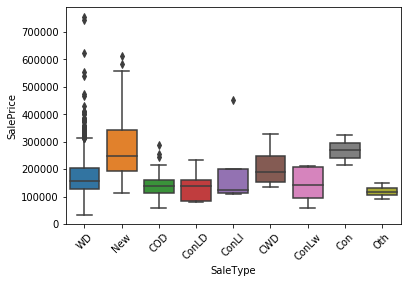

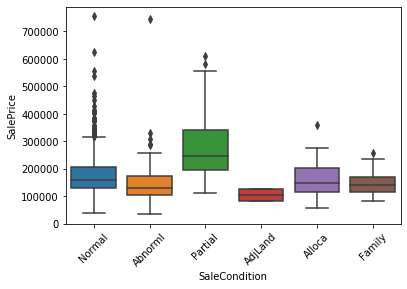

In [8]:
# visualize relationships of categorical variables with SalePrice
cat_cols = list(cat_data)
for item in cat_cols[1:-1]: 
  sns.boxplot(cat_data[item], cat_data['SalePrice'])
  plt.xticks(rotation=45)
  plt.show()


In [9]:
# identify null values in categorical variables of interest
review_list = ['MSZoning','Alley','RoofMatl','ExterQual','BsmtQual','BsmtCond','CentralAir','KitchenQual','GarageFinish','PavedDrive',
               'MiscFeature']
for item in review_list:
  print(item, data[item].isna().sum())

MSZoning 0
Alley 1369
RoofMatl 0
ExterQual 0
BsmtQual 37
BsmtCond 37
CentralAir 0
KitchenQual 0
GarageFinish 81
PavedDrive 0
MiscFeature 1406


## Review of Categorical Variables
The following categorical variables may be of interest in explaining SalePrice, however further analysis of the data is required. Based on means/medians and null values, the variables are eliminated where excessive nulls exist. The remaining variables will be included in a reverse elimination process for the OLS model. 

MiscFeature - 1406 null values of 1460 observations; not enough instances;

PavedDrive - 0 null values; the means/medians vary enough for further consideration;

GarageFinish - only 81 null values; the means/medians vary enough for further consideration;

KitchenQual - 0 null values; the means/medians vary enough for further consideration;

CentralAir - 0 null values; the means/medians vary enough for further consideration;

BsmtCond/BsmtQual - 37 null values; the means/medians vary enough for further consideration;

ExterQual - 0 null values; the means/medians vary enough for further consideration;

Alley - 1369 null values; not enough instances;

MSZoning - 0 null values; the means/medians vary enough for further consideration.







In [10]:
# check correlation of quantitative variables
corr_data.corr()

,LotFrontage,LotArea,OverallQual,OverallCond,Qual_Cond,TotalSqft,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
LotFrontage,1.000000,0.426095,0.251646,-0.059213,0.169429,0.462352,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,0.426095,1.000000,0.105806,-0.005636,0.085616,0.306814,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.251646,0.105806,1.000000,-0.091932,0.717167,0.664830,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059213,-0.005636,-0.091932,1.000000,0.606725,-0.141980,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
Qual_Cond,0.169429,0.085616,0.717167,0.606725,1.000000,0.427739,0.158738,0.458148,0.227100,0.140611,-0.018748,0.148513,0.288875,0.274178,0.272879,0.009067,0.429234,0.037137,0.050253,0.299555,0.182246,0.102207,-0.197303,0.310811,0.308749,0.185629,0.338911,0.330108,0.181662,0.229760,-0.038126,0.042677,0.097423,0.046172,0.026346,0.053557,0.009937,0.565294
TotalSqft,0.462352,0.306814,0.664830,-0.141980,0.427739,1.000000,0.335488,0.338404,0.443391,0.411084,0.049678,0.374540,0.822888,0.797678,0.345689,0.068223,0.880324,0.185943,-0.012238,0.574403,0.239278,0.359459,0.027142,0.678802,0.475416,0.320874,0.529608,0.558466,0.281459,0.342402,-0.045044,0.033084,0.109771,0.175741,-0.011384,0.039084,-0.031278,0.778959
YearBuilt,0.123349,0.014228,0.572323,-0.375983,0.158738,0.335488,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.088866,0.013788,0.550684,0.073741,0.458148,0.338404,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.193458,0.104160,0.411876,-0.128101,0.227100,0.443391,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,0.233633,0.214103,0.239666,-0.046231,0.140611,0.411084,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0

In [11]:
# review variables with highest correlation
review_list2 = ['OverallQual','TotalSqft','GrLivArea','GarageCars']
for item in review_list2:
  print(item, data[item].isna().sum())

OverallQual 0
TotalSqft 0
GrLivArea 0
GarageCars 0


## Review of Quantitative Variables
All 4 quantitative variables have relationships worth exploring for a model. There are no null values in these columns. Below, the distributions are presented. In general, the distributions are near to normal (including the binomials which follow a normal distribution pattern).

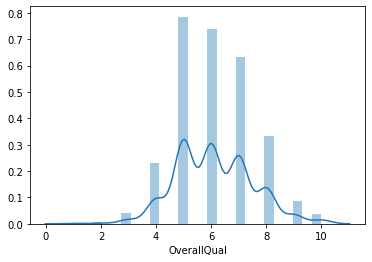

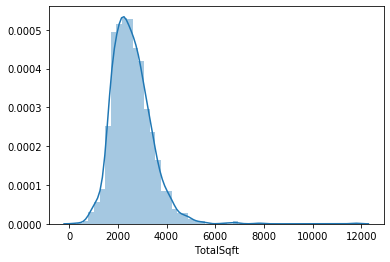

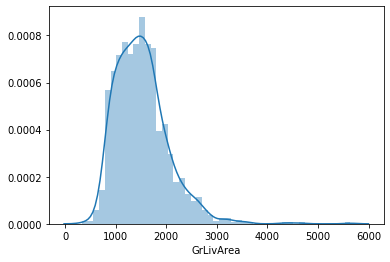

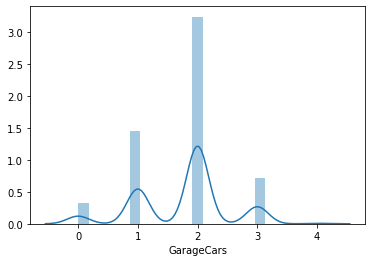

In [0]:
quants = ['OverallQual','TotalSqft','GrLivArea','GarageCars']
for item in quants:
  sns.distplot(data[item])
  plt.show()

In [0]:
# create subset DF with variables of interest only
data2 = data[['OverallQual','TotalSqft','GrLivArea','GarageCars','PavedDrive','GarageFinish','KitchenQual','CentralAir','BsmtCond','BsmtQual',
              'ExterQual','MSZoning','SalePrice']]


In [0]:
data2.head()

,OverallQual,TotalSqft,GrLivArea,GarageCars,PavedDrive,GarageFinish,KitchenQual,CentralAir,BsmtCond,BsmtQual,ExterQual,MSZoning,SalePrice
0,7,2566,1710,2,Y,RFn,Gd,Y,TA,Gd,Gd,RL,208500
1,6,2524,1262,2,Y,RFn,TA,Y,TA,Gd,TA,RL,181500
2,7,2706,1786,2,Y,RFn,Gd,Y,TA,Gd,Gd,RL,223500
3,7,2473,1717,3,Y,Unf,Gd,Y,Gd,TA,TA,RL,140000
4,8,3343,2198,3,Y,RFn,Gd,Y,TA,Gd,Gd,RL,250000


The categorical variables below have an ordinal structure. This allows for replacing the categories with 0...highest value by category (e.g. 0,1,2,3). 

Following the replacement of the below variables, one-hot encoding is utilized for the MSZoning variable.

In [0]:
# replace ordinal categorical variables as appropriate
PD = {'N':0, 'P': 1, 'Y':2}
GF = {'NA':0, 'Unf':1, 'RFn':2, 'Fin':3}
KQ = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
CA = {'N':0, 'Y':1}
BC = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
BQ = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
EQ = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}

In [14]:
data2['PavedDrive'].replace(PD, inplace = True)
data2['GarageFinish'].replace(GF, inplace = True)
data2['KitchenQual'].replace(KQ, inplace = True)
data2['CentralAir'].replace(CA, inplace = True)
data2['BsmtCond'].replace(BC, inplace = True)
data2['BsmtQual'].replace(BQ, inplace = True)
data2['ExterQual'].replace(EQ, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [0]:
# the MSZoning variable is the only nominal variable of interest
data2 = pd.concat([data2, pd.get_dummies(data2['MSZoning'])], axis=1)

In [0]:
data2.describe()

,OverallQual,TotalSqft,GrLivArea,GarageCars,PavedDrive,GarageFinish,KitchenQual,CentralAir,BsmtQual,ExterQual,SalePrice,C (all),FV,RH,RL,RM
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.00000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,2572.893151,1515.463699,1.767123,1.856164,1.715753,2.511644,0.934932,3.489041,2.39589,180921.195890,0.006849,0.044521,0.010959,0.788356,0.149315
std,1.382997,823.598492,525.480383,0.747315,0.496592,0.892831,0.663760,0.246731,0.876478,0.57428,79442.502883,0.082505,0.206319,0.104145,0.408614,0.356521
min,1.000000,334.000000,334.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,34900.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,2014.000000,1129.500000,1.000000,2.000000,1.000000,2.000000,1.000000,3.000000,2.00000,129975.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,6.000000,2479.000000,1464.000000,2.000000,2.000000,2.000000,2.000000,1.000000,4.000000,2.00000,163000.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,7.000000,3008.500000,1776.750000,2.000000,2.000000,2.000000,3.000000,1.000000,4.000000,3.00000,214000.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,10.000000,11752.000000,5642.000000,4.000000,2.000000,3.000000,4.000000,1.000000,5.000000,4.00000,755000.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
# fill null values with 0's as appropriate
data2['GarageFinish'] = data2['GarageFinish'].fillna(0)
data2['BsmtQual'] = data2['BsmtQual'].fillna(0)
data2['BsmtCond'] = data2['BsmtQual'].fillna(0)

In [17]:
data2.round(2)

,OverallQual,TotalSqft,GrLivArea,GarageCars,PavedDrive,GarageFinish,KitchenQual,CentralAir,BsmtCond,BsmtQual,ExterQual,MSZoning,SalePrice,C (all),FV,RH,RL,RM
0,7,2566,1710,2,2,2.0,3,1,4.0,4.0,3,RL,208500,0,0,0,1,0
1,6,2524,1262,2,2,2.0,2,1,4.0,4.0,2,RL,181500,0,0,0,1,0
2,7,2706,1786,2,2,2.0,3,1,4.0,4.0,3,RL,223500,0,0,0,1,0
3,7,2473,1717,3,2,1.0,3,1,3.0,3.0,2,RL,140000,0,0,0,1,0
4,8,3343,2198,3,2,2.0,3,1,4.0,4.0,3,RL,250000,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,2600,1647,2,2,2.0,2,1,4.0,4.0,2,RL,175000,0,0,0,1,0
1456,6,3615,2073,2,2,1.0,2,1,4.0,4.0,2,RL,210000,0,0,0,1,0
1457,7,3492,2340,1,2,2.0,3,1,3.0,3.0,4,RL,266500,0,0,0,1,0
1458,5,2156,1078,1,2,1.0,3,1,3.0,3.0,2,RL,142125,0,0,0,1,0


## Reverse Elimination for Variable Selection - Model Refinement

In [0]:
# set the random seed
RANDOM_SEED = 1
# create the X and y data for train_test_split
X = data2[['OverallQual','TotalSqft','GrLivArea','GarageCars','PavedDrive','GarageFinish',
               'KitchenQual','CentralAir','BsmtCond','BsmtQual','ExterQual','FV','RH','RL','RM']].to_numpy(copy = True)
y = data2['SalePrice'].to_numpy(copy = True)

In [0]:
# create the constant variable, compare regression models for reverse elimination of variables
import statsmodels.regression.linear_model as sm
X = np.append(arr = np.ones((1460,1)).astype(int), values = X, axis = 1)

In [0]:
X_opt = X[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit() # fit OLS to X_opt and Y
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     419.2
Date:                Tue, 10 Dec 2019   Prob (F-statistic):               0.00
Time:                        00:28:00   Log-Likelihood:                -17404.
No. Observations:                1460   AIC:                         3.484e+04
Df Residuals:                    1446   BIC:                         3.491e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.317e+05   6217.434    -21.184      0.000   -1.44e+05    -1.2e+05
x1          1.407e+04   1289.757     10.910      0.000    1.15e+04    1.66e+04
x2            21.3208      2.943      7.244      0.000      15.547      27.094
x3            26.6510      4.163      6.402      0.000      18.485      34.817
x4          1.258e+04   1789.744      7.031      0.000    9073.698    1.61e+04
x5          -679.7642   2163.486     -0.314      0.753   -4923.671    3564.143
x6          2428.4027   1451.529      1.673      0.095    -418.925    5275.730
x7          1.411e+04   2210.800      6.381      0.000    9770.117    1.84e+04
x8          3006.1190   4335.494      0.693      0.488   -5498.412    1.15e+04
x9          2962.5827    788.714      3.756      0.000    1415.437    4509.729
x10         2962.5827    788.714      3.756      0.000    1415.437    4509.729
x11         1.372e+04   2798.225      4.904      0.000    8233.227    1.92e+04
x12         7056.5564   5448.349      1.295      0.195   -3630.957    1.77e+04
x13         9523.6102   9506.660      1.002      0.317   -9124.710    2.82e+04
x14         1.802e+04   2878.288      6.261      0.000    1.24e+04    2.37e+04
==============================================================================
Omnibus:                      422.846   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46817.089
Skew:                          -0.053   Prob(JB):                         0.00
Kurtosis:                      30.741   Cond. No.                     1.49e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.49e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [0]:
X_opt = X[:, [0,1,2,3,4,6,7,8,9,10,11,12,13,14]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit() # fit OLS to X_opt and Y
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     454.4
Date:                Tue, 10 Dec 2019   Prob (F-statistic):               0.00
Time:                        00:30:07   Log-Likelihood:                -17404.
No. Observations:                1460   AIC:                         3.483e+04
Df Residuals:                    1447   BIC:                         3.490e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.324e+05   5835.070    -22.687      0.000   -1.44e+05   -1.21e+05
x1          1.407e+04   1289.302     10.916      0.000    1.15e+04    1.66e+04
x2            21.2951      2.941      7.240      0.000      15.526      27.065
x3            26.7382      4.152      6.439      0.000      18.593      34.884
x4          1.252e+04   1777.034      7.045      0.000    9033.202     1.6e+04
x5          2395.2866   1447.246      1.655      0.098    -443.639    5234.212
x6          1.411e+04   2210.110      6.382      0.000    9770.639    1.84e+04
x7          2707.3055   4228.581      0.640      0.522   -5587.500     1.1e+04
x8          2947.0371    786.915      3.745      0.000    1403.420    4490.654
x9          2947.0371    786.915      3.745      0.000    1403.420    4490.654
x10         1.373e+04   2797.326      4.907      0.000    8238.862    1.92e+04
x11         6897.6842   5423.145      1.272      0.204   -3740.383    1.75e+04
x12         9592.2558   9501.189      1.010      0.313   -9045.321    2.82e+04
x13         1.787e+04   2837.685      6.298      0.000    1.23e+04    2.34e+04
==============================================================================
Omnibus:                      422.935   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46862.644
Skew:                          -0.054   Prob(JB):                         0.00
Kurtosis:                      30.755   Cond. No.                     1.10e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.19e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [0]:
X_opt = X[:, [0,1,2,3,4,6,8,9,10,11,12,13,14]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit() # fit OLS to X_opt and Y
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     478.8
Date:                Tue, 10 Dec 2019   Prob (F-statistic):               0.00
Time:                        00:30:45   Log-Likelihood:                -17424.
No. Observations:                1460   AIC:                         3.487e+04
Df Residuals:                    1448   BIC:                         3.494e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.305e+05   5906.836    -22.089      0.000   -1.42e+05   -1.19e+05
x1          1.563e+04   1283.418     12.176      0.000    1.31e+04    1.81e+04
x2            21.5960      2.981      7.245      0.000      15.749      27.443
x3            26.8396      4.209      6.377      0.000      18.583      35.096
x4          1.346e+04   1795.028      7.499      0.000    9939.940     1.7e+04
x5          2613.9834   1466.558      1.782      0.075    -262.823    5490.790
x6          5078.8581   4269.630      1.190      0.234   -3296.463    1.35e+04
x7          3132.8626    797.093      3.930      0.000    1569.281    4696.444
x8          3132.8626    797.093      3.930      0.000    1569.281    4696.444
x9          2.101e+04   2588.471      8.118      0.000    1.59e+04    2.61e+04
x10         7318.0607   5496.647      1.331      0.183   -3464.183    1.81e+04
x11         8920.7032   9630.082      0.926      0.354   -9969.701    2.78e+04
x12           1.8e+04   2876.283      6.259      0.000    1.24e+04    2.36e+04
==============================================================================
Omnibus:                      416.501   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43286.907
Skew:                          -0.032   Prob(JB):                         0.00
Kurtosis:                      29.675   Cond. No.                     1.71e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.91e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [0]:
X_opt = X[:, [0,1,2,3,4,6,8,9,10]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit() # fit OLS to X_opt and Y
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     686.9
Date:                Tue, 10 Dec 2019   Prob (F-statistic):               0.00
Time:                        00:32:02   Log-Likelihood:                -17477.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1452   BIC:                         3.501e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.102e+05   5690.969    -19.358      0.000   -1.21e+05    -9.9e+04
x1          1.988e+04   1194.193     16.646      0.000    1.75e+04    2.22e+04
x2            26.7879      2.996      8.941      0.000      20.911      32.665
x3            21.5855      4.307      5.012      0.000      13.137      30.034
x4          1.513e+04   1848.300      8.187      0.000    1.15e+04    1.88e+04
x5          5435.6831   1492.277      3.643      0.000    2508.433    8362.933
x6          7747.5652   4338.637      1.786      0.074    -763.101    1.63e+04
x7          3568.8002    812.137      4.394      0.000    1975.713    5161.887
x8          3568.8002    812.137      4.394      0.000    1975.713    5161.887
==============================================================================
Omnibus:                      403.234   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36106.516
Skew:                          -0.053   Prob(JB):                         0.00
Kurtosis:                      27.362   Cond. No.                     1.71e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.88e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [20]:
X_opt = X[:, [0,1,2,3,4,6,9,10]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit() # fit OLS to X_opt and Y
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     799.7
Date:                Tue, 10 Dec 2019   Prob (F-statistic):               0.00
Time:                        23:27:05   Log-Likelihood:                -17479.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1453   BIC:                         3.501e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.052e+05   4975.870    -21.147      0.000   -1.15e+05   -9.55e+04
x1          2.006e+04   1190.589     16.851      0.000    1.77e+04    2.24e+04
x2            27.0174      2.996      9.019      0.000      21.141      32.893
x3            20.9115      4.294      4.870      0.000      12.489      29.334
x4          1.527e+04   1848.148      8.260      0.000    1.16e+04    1.89e+04
x5          5756.2140   1482.558      3.883      0.000    2848.031    8664.397
x6          3685.5192    810.112      4.549      0.000    2096.405    5274.633
x7          3685.5192    810.112      4.549      0.000    2096.405    5274.633
==============================================================================
Omnibus:                      403.633   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35738.269
Skew:                          -0.087   Prob(JB):                         0.00
Kurtosis:                      27.237   Cond. No.                     8.49e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.99e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Reverse Elimination Results
Seven variables remain after reverse elimination. The variables removed were statistically insignificant. A final test is conducted using variance inflation factor to determine collinearity. The test leaves us with 5 variables remaining - OverallQual, TotalSqft, GrLivArea, GarageCars, GarageFinish.

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
for i in range(1, 8):
  print(variance_inflation_factor(X_opt, i))

2.685417651248595
6.0286911145687885
5.042163894318634
1.8894114435437042
1.7354315556268658
inf
inf


/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


## Model Development and Comparison
Below, the data is compiled into training and test sets. The 5 models will be compared/evaluated. Fit times as well as cross-val RMSEs and test set RMSEs will be compared in a summary dataframe.

In [0]:
# create the X and y data for train_test_split
X = data2[['OverallQual','TotalSqft','GrLivArea','GarageCars','GarageFinish']].to_numpy(copy = True)
y = data2['SalePrice'].to_numpy(copy = True)

In [0]:
# Split dataset into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = RANDOM_SEED) 

In [0]:
# fit the OLS model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
start1 = timer()
regressor.fit(X_train, y_train)
end1 = timer()
OLS_train_time = (end1 - start1)

In [25]:
# cross validation with mean RMSE
OLS_xval = cross_val_score(regressor, X_train, y_train, cv=10, scoring= 'neg_mean_squared_error')
OLS_xval = -OLS_xval
OLS_xval = np.sqrt(OLS_xval)
OLS_xval_mn = np.mean(OLS_xval)
OLS_xval_mn

40365.329606187865

In [0]:
# get predictions
OLS_pred = regressor.predict(X_test)

In [27]:
# get the RMSE for the test predictions
from math import sqrt
from sklearn.metrics import mean_squared_error
OLS_rms = sqrt(mean_squared_error(y_test, OLS_pred))
OLS_rms

35366.47741546916

## RF Model 1

In [0]:
 # create regressor object 
rf_regressor1 = RandomForestRegressor(n_estimators = 100, max_depth = 10, random_state = 0) 
# fit the regressor with x and y data 
start2 = timer()
rf_regressor1.fit(X, y)
end2 = timer()
rf1_train_time = (end2 - start2)

In [29]:
# cross validation with average RMSE
rf1_xval = cross_val_score(rf_regressor1, X_train, y_train, cv=10, scoring= 'neg_mean_squared_error')
rf1_xval = -rf1_xval
rf1_xval = np.sqrt(rf1_xval)
rf1_xval_mn = np.mean(rf1_xval)
rf1_xval_mn

36477.6286751935

In [30]:
# get the RF preds
rf1_pred = rf_regressor1.predict(X_test)
rf1_rms = sqrt(mean_squared_error(y_test, rf1_pred))
rf1_rms

14847.882679003318

## RF Model 2

In [0]:
rf_regressor2 = RandomForestRegressor(n_estimators = 200, max_depth = 10, random_state = 0) 
start3 = timer()
rf_regressor2.fit(X, y)
end3 = timer()
rf2_train_time = (end3 - start3)

In [32]:
rf2_xval = cross_val_score(rf_regressor2, X_train, y_train, cv=10, scoring= 'neg_mean_squared_error')
rf2_xval = -rf2_xval
rf2_xval = np.sqrt(rf2_xval)
rf2_xval_mn = np.mean(rf2_xval)
rf2_xval_mn

36613.017057696416

In [33]:
rf2_pred = rf_regressor2.predict(X_test)
rf2_rms = sqrt(mean_squared_error(y_test, rf2_pred))
rf2_rms

14905.08233756068

## RF Model 3

In [0]:
rf_regressor3 = RandomForestRegressor(n_estimators = 100, max_depth = 10, min_samples_split = 3, random_state = 0) 
start4 = timer()
rf_regressor3.fit(X, y)
end4 = timer()
rf3_train_time = (end4 - start4)

In [35]:
rf3_xval = cross_val_score(rf_regressor3, X_train, y_train, cv=10, scoring= 'neg_mean_squared_error')
rf3_xval = -rf3_xval
rf3_xval = np.sqrt(rf3_xval)
rf3_xval_mn = np.mean(rf3_xval)
rf3_xval_mn

36242.817202616985

In [36]:
rf3_pred = rf_regressor3.predict(X_test)
rf3_rms = sqrt(mean_squared_error(y_test, rf3_pred))
rf3_rms

15252.577456274825

## RF Model 4

In [0]:
rf_regressor4 = RandomForestRegressor(n_estimators = 200, max_depth = 10, min_samples_split = 3, random_state = 0) 
start5 = timer()
rf_regressor4.fit(X, y)
end5 = timer()
rf4_train_time = (end5 - start5)

In [38]:
rf4_xval = cross_val_score(rf_regressor4, X_train, y_train, cv=10, scoring= 'neg_mean_squared_error')
rf4_xval = -rf4_xval
rf4_xval = np.sqrt(rf4_xval)
rf4_xval_mn = np.mean(rf4_xval)
rf4_xval_mn

36366.5592028733

In [39]:
rf4_pred = rf_regressor4.predict(X_test)
rf4_rms = sqrt(mean_squared_error(y_test, rf4_pred))
rf4_rms

15237.077023864966

## Review and Summary
...

In [41]:
# build a df to review the results
mod1stats = {'Model Name': 'OLS', 'Estimators': 'NA', 'Max Depth': 'NA', 'Min Samples Split': 'NA',
'Fit Time': OLS_train_time, 'Test RMSE': OLS_rms}
mod2stats = {'Model Name': 'RF 1', 'Estimators': 100, 'Max Depth': 10, 'Min Samples Split': 2,
'Fit Time': rf1_train_time, 'Test RMSE': rf1_rms}
mod3stats = {'Model Name': 'RF 2', 'Estimators': 200, 'Max Depth': 10, 'Min Samples Split': 2,
'Fit Time': rf2_train_time, 'Test RMSE': rf2_rms}
mod4stats = {'Model Name': 'RF 3', 'Estimators': 100, 'Max Depth': 10, 'Min Samples Split': 3,
'Fit Time': rf3_train_time, 'Test RMSE': rf3_rms}
mod5stats = {'Model Name': 'RF 4', 'Estimators': 200, 'Max Depth': 10, 'Min Samples Split': 3,
'Fit Time': rf4_train_time, 'Test RMSE': rf4_rms}
df = pd.DataFrame.from_dict([mod1stats, mod2stats, mod3stats, mod4stats, mod5stats])
index = pd.Index(['OLS', 'RF Model 1', 'RF Model 2', 'RF Model 3', 'RF Model 4'])
df.index = index
df

,Model Name,Estimators,Max Depth,Min Samples Split,Fit Time,Test RMSE
OLS,OLS,NA,NA,NA,0.030378,35366.477415
RF Model 1,RF 1,100,10,2,0.332359,14847.882679
RF Model 2,RF 2,200,10,2,0.642013,14905.082338
RF Model 3,RF 3,100,10,3,0.320611,15252.577456
RF Model 4,RF 4,200,10,3,0.641863,15237.077024


Based on the results displayed above, the first Random Forest is the best model. The fit time is acceptable, especially considering the RMSE for the test data predictions. In general, all of the RF models are superior to the OLS model considering RMSE. Further experiments with the RF hyperparameters may produce improved results. The number of estimators for the RF models increases the fit (training) time - in this case 2x the number of estimators led to a ~2x increase in fit time.

To develop an improved model, further feature engineering experiments should be conducted. Gradient boosting and/or deep learning models can also be explored. 

A final point is that more extensive EDA may reveal alternative approaches to model development. 